<h1><center> Pairs Trading Strategy</center></h1>
<h4><center> Anthony Li </center></h4>
<h4><center> August 2023 </center></h4>

## Introduction
Systematic Investment Strategies, often referred to as systematic trading or quantitative investing, are investment approaches that rely on data-driven, rule-based methodologies to make trading decisions. These strategies aim to remove human emotion and subjectivity from the investment process, instead relying on algorithms and statistical models to guide decision-making. Here's a summary of key points regarding systematic investment strategies:

A pairs trading strategy is a market-neutral trading strategy that involves identifying two closely related assets, such as two stocks, whose prices move together. Once these pairs of stocks are identified, the idea is to trade any divergence in the prices in hope that the prices will converge once again in the near future. This usually involves buying the 'cheaper' asset and shorting the 'expensive' asset.

In this project, we will build a basic pairs trading strategy and follow up by exploring different ways to improve on this. We will analyse the performance of these strategies and discuss any assumptions made when backtesting. The project will involve difference based approach, cointegration, kalman filters, copulas, and PCA.

## Table of Contents
- [Libraries and Preprocessing Data](#Libraries-and-Preprocessing-Data)
- [1. Distance Based Pairs Trading Strategy](#section-1)
  - [Subsection 1.1](#subsection-1-1)
  - [Subsection 1.2](#subsection-1-2)
- [2. Cointegration Approach: Basic](#section-2)
  - [2.1 What is cointegration?](#subsection-2-1)
  - [2.2 Identifying Pairs: Engle and Granger Test for Cointegration](#subsection-2-1)
  - [2.3 Trading Strategy and Returns Calculation](#subsection-2-1)
  - [2.4 Performance and Analysis](#subsection-2-1)

- [3. Cointegration Approach: Annual Cointegration and Stop-Loss Implementation](#section-3)
  - [3.1 Identifying Cointegrating Pairs Annually](#subsection-3-1)
  - [3.2 Calculating Strategy Returns and Implementing a Stop-loss](#subsection-3-2)
  - [3.3 Performance and Analysis](#subsection-3-3)
- [4. Cointegration Approach: Adding a Profit Exit Strategy](#section-4)
  - [Subsection 2.1](#subsection-4-1)
- [5. Cointegration Approach: Relaxing Assumption of Daily Rebalancing](#section-5)
  - [Subsection 2.1](#subsection-5-1)
- [6. Kalman Filter](#section-6)
  - [Subsection 2.1](#subsection-6-1)
- [7. Copula Approach](#section-7)
  - [Subsection 2.1](#subsection-7-1)
- [8. PCA Approach](#section-8)
  - [Subsection 2.1](#subsection-8-1)



## Libraries and Preprocessing Data
Before we begin the project, we will import all the relevant libraries and data we will be using in the project.

In [ ]:
# Importing Libraries
import statsmodels.api as sm
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter

In [3]:
# Connecting Google Collaboratory to Google Drive folder
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir("./gdrive/My Drive/Quantitative Finance Projects/Statistical Arbitrage Trading Strategy/")

Mounted at /content/gdrive


In [ ]:
# Importing .csv of the prices of all stocks in the S&P500
Prices = pd.read_csv("price.csv", index_col=0)

# For simplicity, dropping all stocks that have any NaN
Prices =Prices.dropna(axis=1)

Prices.head()

In [ ]:
# Define the S&P 500 symbol
sp500_symbol = "^GSPC"

# Define the start and end dates
start_date = "2011=0-01-03"
end_date = "2019-12-31"

# Fetch historical data for the S&P 500 index
sp500_data = yf.download(sp500_symbol, start=start_date, end=end_date)

In [ ]:
sp500_returns = sp500_data['Adj Close'].pct_change()

## 1 Distanced Based Pairs Trading Strategy


## 2 Cointegration Approach: Basic

### 2.1 What is conintegration?
Cointegration is a statistical concept used in time series analysis and econometrics. It refers to the long-term relationship or equilibrium between two or more non-stationary time series variables. In simpler terms, cointegration helps us understand how different variables are related over time, even if they individually exhibit trends or fluctuations.

Here are the key points to understand about cointegration:

1. **Non-stationarity:** Time series data often exhibit trends, seasonality, or other forms of non-stationarity, meaning their statistical properties change over time. Non-stationary data can make it challenging to establish meaningful relationships.

2. **Cointegration tests:** Cointegration tests are used to determine whether a set of non-stationary time series variables share a long-term relationship. The most commonly used cointegration test is the Engle-Granger test or the Johansen test.

3. **Long-term equilibrium:** Cointegration implies that, despite short-term fluctuations, the variables move together in the long run. In other words, there is a stable, linear combination of these variables that remains constant over time. This relationship is often represented as an error correction model (ECM).

Trading strategies: Cointegration can also be used in pairs trading strategies. Traders look for pairs of assets that are cointegrated, meaning they tend to move together in the long run, and then create trading strategies that capitalize on short-term deviations from this relationship.

Cointegration is a valuable tool for understanding and modeling complex relationships between time series data. It helps researchers and analysts identify meaningful connections between variables, even when those variables exhibit non-stationarity in their raw form.

### 2.2 Identifying Pairs: Engle and Granger Test for Cointegration
The Engle-Granger test for cointegration is a two-step procedure used to test whether two non-stationary time series variables are cointegrated, meaning they have a long-term, stable relationship. Here are the detailed steps for conducting the Engle-Granger test:

**Step 1: Individual Time Series Unit Root Tests**
The first step involves conducting unit root tests on each of the individual time series variables to determine if they are stationary. Common unit root tests used for this purpose include the Augmented Dickey-Fuller (ADF) test or the Phillips-Perron test. The null hypothesis of these tests is that the series has a unit root (it is non-stationary). Since stock prices are known to be non-stationary, we will skip this step and focus solely on the stationarity of the price difference instead.

**Step 2: Cointegration Test**
If any of the original time series are found to be non-stationary, we can move onto the cointegration test.

- **Regress One Variable on the Other:**
  - Choose one of the non-stationary variables to be the dependent variable, and the other to be the independent variable.
  - Estimate a linear regression model (with no intercept): $Y_1 = \beta Y_2 + \epsilon$ where the intercept, $\beta$, is the coefficient of $Y_2$, and $\epsilon$ is the error term. Note that the error term is also the price difference.
- **Check Residuals for Stationarity:**
  - Extract the estimate residuals, $\epsilon = Y_1 - \hat{Y_1}$
  - Conduct a unit root test on the residuals (e.g., ADF test) to determine if the price difference is stationary
  - The null hypothesis is that the residuals have a unit root (non-stationary), and the alternative hypothesis is that they are stationary
- **Interpret the Cointegration Test:**
  - If the test on the residuals rejects the null hypothesis of non-stationarity, this suggests cointegration between $Y_1$ and $Y_2$.
  - This implies that the price difference between the two stocks should be mean reverting.


#### Pearson Correlation Coefficient
Assuming we have prices for 500 stocks, there are 124,750 different pairs to test for cointegration. Identifying pairs by cointegrating all possible combinations is extremely computationally expensive and many of these combinations will not cointegrate. To reduce the number of computations, we have required that the correlation between the asset returns is $>0.6$ before we test for cointegration.

We decided to use asset returns instead of asset prices as returns are stationary. Correlation in non-stationary series can be spurious and lead to false conclusions.

However, cointegrated stocks do not necessarily have highly correlated returns. In fact, the relationship between cointegrated stocks is more nuanced than simple correlation. Cointegration implies a long-term, stable relationship between two or more non-stationary time series variables. This relationship is not about short-term movements or day-to-day correlations in returns but rather how these stocks move together over an extended period. Here are a few key points to consider:

In [ ]:
# Creating a loop to identify stocks that cointegrate
columns = ['Stock1', 'Stock2', 'Beta']

# Predefining empty dataframe to store the pairs of stocks and the corresponding beta
Pairs = pd.DataFrame(columns=columns)

for i in range(len(Prices.columns)):

  # Embedded for loop to avoid duplicate pairs
  for j in range(i+1,len(Prices.columns)):

    stock1 = Prices.iloc[0:252,i]
    stock2 = Prices.iloc[0:252,j]

    returns1=stock1.pct_change()[1:]
    returns2=stock2.pct_change()[1:]

    correlation = np.corrcoef(returns1,returns2)[0,1]

    if correlation > 0.6:
     # Creating a regression model with NO INTERCEPT using the past 252 days of data
      model = sm.OLS(stock1, stock2).fit()
      beta = model.params[0]
      residuals = model.resid

      # Carrying out ADF stationarity test on the residuals of the linear model
      result = sm.tsa.adfuller(residuals)
      p_value = result[1]

      # Storing the pairs of stocks IFF the residuals (price difference) are stationary
      if p_value < 0.02:
        new_row = {'Stock1': Prices.columns[i], 'Stock2': Prices.columns[j], 'Beta': beta}
        Pairs = Pairs.append(new_row, ignore_index=True)

In [7]:
Pairs.head()

,Stock1,Stock2,Beta
0,A,CCL,0.764573
1,A,TER,2.045465
2,A,TROW,0.561766
3,AAPL,KLAC,0.407996
4,ADI,ALB,0.625797


### 2.3 Trading Strategy and Returns Calculation
Now that we have obtained a set of pairs that are cointegrated, we can now formulate a trading strategy and backtest this to calculate historical returns of the strategy. Note that we have used data in 2010 (252 trading days) to identify these pairs, i.e. the training period. Therefore we must be careful not to trade during this period as this will result in hindsight bias and likely produce significantly high returns.

In this cointegration strategy, we will not be testing for cointegration from 2011 through to end of 2019 and will only trade the pairs already identified using data in 2010. The next section will investigate the performance if we test for cointegration every year.

Since pairs trading strategy is market-neutral and hence self-funding, we will assume both the long leg and short leg of the trade will have the exact same value. More specifically, we will assume that the manager has a £1,000,000 AUM and that each leg of the trade has a value of £10,000 (1% of AUM). For simplicity, we will also assume that the trader will rebalance the portfolio everyday such that both the long and short leg will have the same value at the start of each trading day. This means that the daily return will be calculated as $r_i = r_i^L - r_i^S$ where $r_i^L$ and $r_i^S$ are the daily returns on the long-leg and short-leg respectively.

In this strategy, we will have no stop-loss and let open trades stay open until convergence. In cases of continued divergence, we will absorb all losses for now. We will implement stop-losses in following strategies.

It is important to note that this is all theoretical as there are trading costs and other market frictions in the real-world.

In [8]:
# Defining a function which produces the returns for a given pair
def pairs_returns(pair):
  stock1, stock2, beta = pair

  price1 = Prices[stock1]
  price2 = Prices[stock2]

  returns1 = price1.pct_change()
  returns2 = price2.pct_change()

  difference = price1 - beta*price2

  # We will use the rolling mean and sd to generate the trading signal
  mean = difference.rolling(window=252).mean()
  sd = difference.rolling(window=252).std()

  # if indicator = 1, then stock1 is overpriced relative to stock2 hence short stock1 and buy stock2
  # if indicator = 0, do nothing
  # if indicator = -1, then stock1 is underpriced relative to stock2 hence buy stock1 and short stock2

  indicator = ((difference > mean + sd).astype(float) )- ((difference < mean -sd).astype(float))
  indicator = indicator.shift()

  returns = indicator[252:] * (returns2 - returns1)[252:]

  return returns

In [9]:
returns = 0
for i in range(Pairs.shape[0]):
  row = Pairs.iloc[i,:]
  returns += pairs_returns(row)

# Divide by 100 as each trade is 1% of the AUM
returns = returns/100

### 2.4 Performance and Analysis
To investigate the performance of the strategy, we will plot the cumulative returns over time to identify periods where the strategy performs well. Additionally, we will regress the strategy returns against the SP500 returns to estimate the alpha and beta of the strategy.


In [ ]:
Dates =  pd.to_datetime(Prices.iloc[252:,:].index)

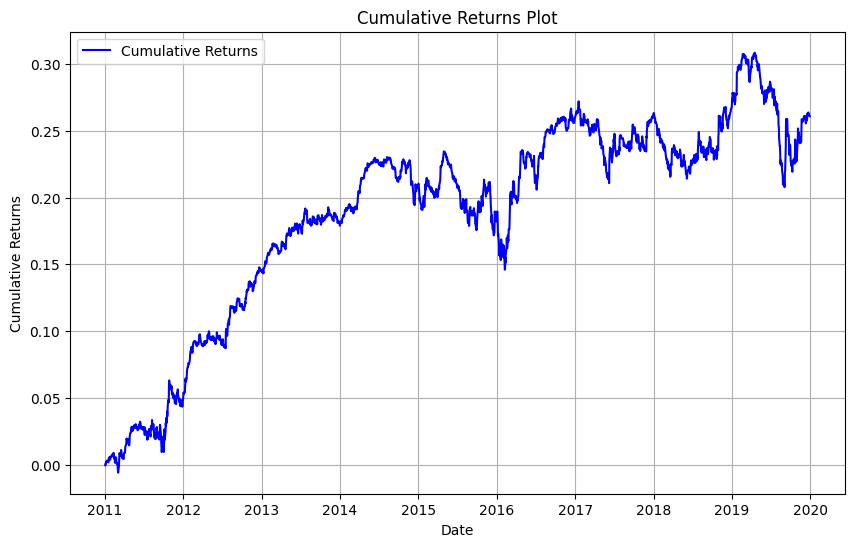

In [30]:
# Calculate cumulative returns
cum_returns = (1 + returns).cumprod() - 1

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(Dates, cum_returns, linestyle='-', color='b', label='Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns Plot')

# Change tick frequency to display only years
ax = plt.gca()
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))

plt.grid(True)
plt.legend()
plt.show()

In [43]:
# Perform regression analysis to calculate alpha and beta
X = sm.add_constant(sp500_returns[1:])
y = list(returns[1:])
model = sm.OLS(y, X).fit()

alpha = model.params['const']
beta = model.params['Adj Close']

# Print alpha and beta
print(f'Alpha: {alpha:.4f}')
print(f'Beta: {beta:.4f}')

Alpha: 0.0001
Beta: 0.0604


## 3 Cointegration Approach: Annual Cointegration and Stop-Loss Implementation
One of the drawbacks of the Strategy 1 is that the cointegrating pairs are selected in the first year of the data and are used for trading in the following 9 years. A better approach could be to test for cointegration annually and update the set of cointegrating pairs that we are trading each year. This means we can remove pairs with structural breaks that are no long cointegrating. It is likely that the these pairs are causing significant losses.


### 3.1 Identifying Cointegrating Pairs Annually
The first step is to identify the cointegrating pairs annually. We will use the same method of testing for cointegration as Strategy 1 but repeat this for each year.

In [44]:
Prices = pd.read_csv("price.csv", index_col=0)
Prices = Prices.dropna(axis=1)

In [12]:
#Prices = Prices.iloc[:1250,:300]

In [45]:
Dates = Prices.index

In [46]:
from datetime import datetime
# Extract the year from the dates
years = np.array([np.datetime64(date).item().year for date in Dates.values])

In [47]:
Prices['Year'] = years

In [ ]:
# Creating a loop to identify stocks that cointegrate
columns = ['Year', 'Stock1', 'Stock2', 'Beta', 'p-value', 'correlation']

# Predefining empty dataframe to store the pairs of stocks and the corresponding beta
Pairs = pd.DataFrame(columns=columns)

for i in range(len(Prices.columns)):

  # Embedded for loop to avoid duplicate pairs
  for j in range(i+1,len(Prices.columns)):

    for year in np.unique(years):

      stock1 = Prices[Prices['Year'] == year].iloc[:,i]
      stock2 = Prices[Prices['Year'] == year].iloc[:,j]

      returns1=stock1.pct_change()[1:]
      returns2=stock2.pct_change()[1:]

      correlation = np.corrcoef(returns1,returns2)[0,1]

      # To improve efficiency, we will only cointegrate if the correlation is at least 0.9
      if correlation > 0.6:

        # Creating a regression model with NO INTERCEPT using the past 252 days of data
        model = sm.OLS(stock1, stock2).fit()
        beta = model.params[0]
        residuals = model.resid

        # Carrying out ADF stationarity test on the residuals of the linear model
        result = sm.tsa.adfuller(residuals)
        p_value = result[1]

        # Storing the pairs of stocks IFF the residuals (price difference) are stationary
        if p_value < 0.02:
          new_row = {'Year': year, 'Stock1': Prices.columns[i], 'Stock2': Prices.columns[j], 'Beta': beta, 'p-value': p_value, 'correlation': correlation}
          Pairs = Pairs.append(new_row, ignore_index=True)

In [49]:
Pairs

,Year,Stock1,Stock2,Beta,p-value,correlation
0,2011,A,AIG,1.049007,0.018492,0.680857
1,2010,A,CCL,0.764573,0.002770,0.680549
2,2010,A,TER,2.045465,0.004527,0.626445
3,2010,A,TROW,0.561766,0.014267,0.684458
4,2015,AAL,UAL,0.717178,0.015241,0.789329
...,...,...,...,...,...,...
2482,2015,WAT,WFC,2.804945,0.010612,0.669791
2483,2018,WEC,XEL,1.365985,0.009663,0.928174
2484,2010,WFC,ZION,1.080414,0.006489,0.695437
2485,2011,WMB,WRB,1.327040,0.004831,0.615867


### 3.2 Calculating Strategy Returns and Implementing a Stop-loss
Another major drawback of Strategy 1 is that trades remain open until convergence. It is possible for certain pairs with structural breaks to continue diverging and hence incur huge losses. I have decided to set a stop-loss at 3 standard deviations away from the mean price difference.

In [50]:
# Defining a function which produces the returns for a given pair
def pairs_returns(pair):
  year, stock1, stock2, beta, p_value, correlation = pair

  price1 = Prices[stock1]
  price2 = Prices[stock2]

  returns1 = price1.pct_change()[Prices['Year'] == year+1]
  returns2 = price2.pct_change()[Prices['Year'] == year+1]

  difference = price1 - beta*price2

  mean = difference.rolling(window=251).mean()
  sd = difference.rolling(window=251).std()

  # if indicator = 1, then stock1 is overpriced relative to stock2 hence short stock1 and buy stock2
  # if indicator = 0, do nothing
  # if indicator = -1, then stock1 is underpriced relative to stock2 hence buy stock1 and short stock2

  indicator = ((difference > mean + sd).astype(float)) - ((difference > mean+3*sd).astype(float))  - ((difference < mean -sd).astype(float)) +((difference < mean -3*sd).astype(float))
  indicator = indicator.shift()[Prices['Year'] == year+1]

  returns = indicator * (returns2 - returns1)

  return returns

In [51]:
total_returns = []
for year in np.unique(years):

  annual_returns = 0

  for i in range(Pairs[Pairs['Year'] == year].shape[0]):

    row = Pairs[Pairs['Year'] == year].iloc[i,:]
    annual_returns += pairs_returns(row)

  total_returns = np.concatenate((total_returns, annual_returns))

In [52]:
total_returns.shape

(2263,)

In [53]:
Dates =  pd.to_datetime(Prices[Prices['Year']!=2010].index)
Dates.shape

(2263,)

In [64]:
annual_returns_new = total_returns /100

### 3.3 Performance and Analysis


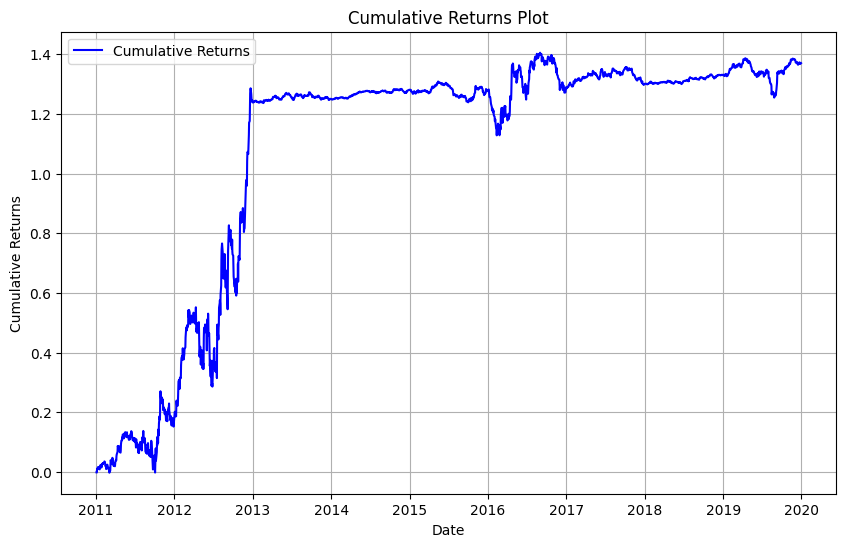

In [65]:
# Calculate cumulative returns
cum_returns = (1 + annual_returns_new).cumprod() - 1

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(
Dates, cum_returns, linestyle='-', color='b', label='Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns Plot')

# Change tick frequency to display only years
ax = plt.gca()
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))

plt.grid(True)
plt.legend()
plt.show()

In [66]:
strategy_returns = pd.DataFrame({'Date': Dates, 'Returns': annual_returns_new })

In [67]:
# Convert the 'Date' column to a datetime data type
strategy_returns['Date'] = pd.to_datetime(strategy_returns['Date'])

# Set 'Date' as the index
strategy_returns.set_index('Date', inplace=True)

# Calculate key performance metrics using pyfolio
returns = strategy_returns['Returns']

In [68]:
# Perform regression analysis to calculate alpha and beta
X = sm.add_constant(sp500_returns[1:])
y = returns[1:]
model = sm.OLS(y, X).fit()

alpha = model.params['const']
beta = model.params['Adj Close']

# Print alpha and beta
print(f'Alpha: {alpha:.4f}')
print(f'Beta: {beta:.4f}')

Alpha: 0.0003
Beta: 0.1802


# IDEAS
Consider weighting each pair based on how strongly they cointegrate.

Johansen Cointegration test for multi-assets trading rather than just pairs.